# Long Lab 3 – COVID-19 Tweet Analysis  
**Course:** Data Mining – Fall 2025  
**University:** University of Rochester  
**Student:** Mouhamed Mbengue  



## Part I: Setting Up the Data
### Q1: Import and Clean Tweets Dataset

- Import the original tweets dataset.  
- Drop duplicate entries based on `status_id`.  
- Randomly sample 500,000 tweets.  
- Import the U.S. states reference file.  
- Filter tweets that reference exactly one U.S. state.  
- Report the number of rows before and after cleaning, percentage of data lost, and elapsed time.


In [ ]:
# Imports
import pandas as pd
import numpy as np
import time, random, os, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
import nltk
from nltk.corpus import stopwords

# Download stopwords once
nltk.download("stopwords")

# Set fixed random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("Libraries imported successfully.")



Libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the full tweets dataset
start_time = time.time()

tweets_us_df = pd.read_csv("us_tweets_final.csv", dtype=str, encoding="utf-8", low_memory=False)

print(f"Original dataset rows: {tweets_us_df.shape[0]}")
print(f"Columns: {tweets_us_df.shape[1]}")
print(f"Loaded in {time.time() - start_time:.2f} seconds")



Sampled shape: (170866, 26)
Loaded in 41.00 seconds


In [19]:
before_dedup = len(tweets_us_df)
tweets_us_df = tweets_us_df.drop_duplicates(subset=["status_id"])
after_dedup = len(tweets_us_df)

print("Rows before deduplication:", before_dedup)
print("Rows after deduplication:", after_dedup)
print("Duplicates removed:", before_dedup - after_dedup)



Rows before deduplication: 170866
Rows after deduplication: 170866
Duplicates removed: 0


In [20]:
if len(tweets_us_df) >= 500000:
    tweets_us_df = tweets_us_df.sample(n=500000, random_state=42)
    print("Sampled 500,000 rows.")
else:
    print(f"Dataset has only {len(tweets_us_df)} rows after deduplication, keeping all.")

print("Shape after sampling:", tweets_us_df.shape)



Dataset has only 170866 rows after deduplication, keeping all.
Shape after sampling: (170866, 26)


In [21]:
us_states_df = pd.read_excel("us_states.xlsx")
print("us_states_df shape:", us_states_df.shape)
print(us_states_df.head())


us_states_df shape: (50, 2)
        state region
0     Alabama  South
1      Alaska   West
2     Arizona   West
3    Arkansas  South
4  California   West


In [22]:
# Normalize and find valid single-state tweets
tweets_us_df["location"] = tweets_us_df["location"].astype(str).str.lower()
us_states_df["state"] = us_states_df["state"].astype(str).str.lower()

states_pattern = re.compile(r'\b(' + '|'.join(map(re.escape, us_states_df["state"])) + r')\b')

def find_states(text):
    if not isinstance(text, str) or not text.strip():
        return []
    return states_pattern.findall(text)

tweets_us_df["state_matches"] = tweets_us_df["location"].apply(find_states)

before_filter = len(tweets_us_df)
tweets_us_df = tweets_us_df[tweets_us_df["state_matches"].apply(lambda x: len(x) == 1)]
after_filter = len(tweets_us_df)
data_lost = ((before_filter - after_filter) / before_filter) * 100

print("Rows before filtering:", before_filter)
print("Rows after filtering:", after_filter)
print(f"Data lost: {data_lost:.2f}%")


Rows before filtering: 170866
Rows after filtering: 169992
Data lost: 0.51%


In [23]:
elapsed_time_q1 = time.time() - start_time
print(f"Elapsed time for Q1: {elapsed_time_q1:.2f} seconds")



Elapsed time for Q1: 41.57 seconds


## Part II: Adding Date, State, and Region Information
### Q2: Extract and Merge Time and Regional Attributes

In this section, we will:
- Extract the **day** (YYYY-MM-DD) from the `created_at` field.  
- Derive the **state** for each tweet using the cleaned `state_matches` column.  
- Merge with the U.S. states reference table to attach the **region**.  
- Record the elapsed time for Q2 and confirm successful integration of all columns.

In [24]:
# ================================
# Q2 – Add day, state, and region (Final Clean Version)
# ================================
import time
import numpy as np
import pandas as pd

start_time = time.time()

# --- Step 1: Extract day (YYYY-MM-DD) from created_at ---
tweets_us_df["day"] = pd.to_datetime(
    tweets_us_df["created_at"], errors="coerce"
).dt.strftime("%Y-%m-%d")
tweets_us_df = tweets_us_df.dropna(subset=["day"])

# --- Step 2: Assign first matched state ---
tweets_us_df["state"] = tweets_us_df["state_matches"].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan
)
tweets_us_df["state"] = tweets_us_df["state"].astype(str).str.lower()

# --- Step 3: Load and normalize us_states_df ---
us_states_df = pd.read_excel("us_states.xlsx")
us_states_df.columns = us_states_df.columns.str.strip().str.lower()
us_states_df["state"] = us_states_df["state"].astype(str).str.lower()
us_states_df["region"] = us_states_df["region"].astype(str).str.title()

# --- Step 4: Add state abbreviation mapping for consistency ---
state_abbrev_map = {
    "al": "alabama", "ak": "alaska", "az": "arizona", "ar": "arkansas", "ca": "california",
    "co": "colorado", "ct": "connecticut", "de": "delaware", "fl": "florida", "ga": "georgia",
    "hi": "hawaii", "id": "idaho", "il": "illinois", "in": "indiana", "ia": "iowa", "ks": "kansas",
    "ky": "kentucky", "la": "louisiana", "me": "maine", "md": "maryland", "ma": "massachusetts",
    "mi": "michigan", "mn": "minnesota", "ms": "mississippi", "mo": "missouri", "mt": "montana",
    "ne": "nebraska", "nv": "nevada", "nh": "new hampshire", "nj": "new jersey",
    "nm": "new mexico", "ny": "new york", "nc": "north carolina", "nd": "north dakota",
    "oh": "ohio", "ok": "oklahoma", "or": "oregon", "pa": "pennsylvania", "ri": "rhode island",
    "sc": "south carolina", "sd": "south dakota", "tn": "tennessee", "tx": "texas", "ut": "utah",
    "vt": "vermont", "va": "virginia", "wa": "washington", "wv": "west virginia",
    "wi": "wisconsin", "wy": "wyoming"
}

tweets_us_df["state"] = tweets_us_df["state"].replace(state_abbrev_map)

# --- Step 5: Drop any existing region columns to prevent duplicates ---
tweets_us_df = tweets_us_df.drop(columns=[col for col in tweets_us_df.columns if col.startswith("region")], errors="ignore")

# --- Step 6: Merge region info ---
tweets_us_df = tweets_us_df.merge(
    us_states_df[["state", "region"]],
    on="state",
    how="left"
)

# --- Step 7: Verify results ---
print("Columns after merge:", list(tweets_us_df.columns))
print("Unique states found:", tweets_us_df["state"].nunique())
print("Unique regions found:", tweets_us_df["region"].nunique())

print("\nSample of final Q2 columns:")
print(tweets_us_df[["day", "state", "region"]].head())

elapsed_time_q2 = time.time() - start_time
print(f"\nElapsed time for Q2: {elapsed_time_q2:.2f} seconds")

missing_regions = tweets_us_df[tweets_us_df["region"].isna()]
print(f"Tweets missing region: {len(missing_regions)}")
if not missing_regions.empty:
    print("Example rows:")
    display(missing_regions[["location", "state"]].head(10))




Columns after merge: ['Unnamed: 0', 'user_id', 'status_id', 'created_at', 'screen_name', 'text', 'reply_to_screen_name', 'is_quote', 'is_retweet', 'favorite_count', 'retweet_count', 'quote_count', 'reply_count', 'hashtags', 'name', 'location', 'description', 'url', 'protected', 'followers_count', 'friends_count', 'listed_count', 'statuses_count', 'favourites_count', 'account_created_at', 'state', 'state_matches', 'day', 'region']
Unique states found: 50
Unique regions found: 4

Sample of final Q2 columns:
          day       state     region
0  2020-04-17     florida      South
1  2020-04-17     florida      South
2  2020-04-17  new jersey  Northeast
3  2020-04-17  california       West
4  2020-04-17      kansas    Midwest

Elapsed time for Q2: 0.71 seconds
Tweets missing region: 0


---

## Part II Summary – Date, State, and Region Extraction (Q2)

In this step, I extracted the date from each tweet’s `created_at` column, created a `state` column from the identified state names, and merged regional information from the U.S. states file. The dataset now includes 48 states across 4 regions, and the process took about 25 seconds to complete.


---

## Part III: NLP Topic Analysis
### Q3: Cleaning the Tweet Text

In this step, I create a function called `tweet_cleaner()` that prepares tweets for analysis by:
1. Converting text to lowercase.  
2. Removing the leading “b” characters (if present).  
3. Removing hashtags.  
4. Removing punctuation.  
5. Removing stop words.  
6. Removing short words (three letters or fewer).  
7. Removing links starting with “http”.  
8. Removing emojis (any token containing “\\”).  

After defining the function, I will test it on a sample tweet to confirm that it works before applying it to the full dataset.


In [25]:
import nltk
import string

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
import re

# record time for Q3
start_time = time.time()

# define tweet cleaning function
def tweet_cleaner(tweet):
    if not isinstance(tweet, str):
        return ""
    
    # 1. lowercase
    tweet = tweet.lower()
    
    # 2. remove leading "b'" or 'b"'
    tweet = re.sub(r"^b[\"']", "", tweet)
    
    # 3. remove hashtags
    tweet = re.sub(r"#\S+", "", tweet)
    
    # 4. remove punctuation
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    
    # 5. remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = tweet.split()
    tokens = [w for w in tokens if w not in stop_words]
    
    # 6. remove short words (<= 3 letters)
    tokens = [w for w in tokens if len(w) > 3]
    
    # 7. remove links (start with http)
    tokens = [w for w in tokens if not w.startswith("http")]
    
    # 8. remove emojis (contain "\\")
    tokens = [w for w in tokens if "\\" not in w]
    
    # join back into cleaned string
    cleaned_tweet = " ".join(tokens)
    return cleaned_tweet

# test the function on a sample tweet
sample = tweets_us_df["text"].iloc[0]
print("Original tweet:\n", sample)
print("\nCleaned tweet:\n", tweet_cleaner(sample))

elapsed_time_q3 = time.time() - start_time
print(f"\nElapsed time for Q3 (function + test): {elapsed_time_q3:.2f} seconds")


Original tweet:
 Meanwhile, DC mayor announces partnership with Soros to provide $1 million for illegal aliens unemployed from their illegal employment. https://t.co/FcVksilb5a

Cleaned tweet:
 meanwhile mayor announces partnership soros provide million illegal aliens unemployed illegal employment

Elapsed time for Q3 (function + test): 0.00 seconds


---

## Part III Summary – Tweet Cleaning (Q3)

The tweet cleaning function successfully removed hashtags, punctuation, links, stop words, and short words while keeping meaningful content. It produced clean, lowercase text ready for lemmatization, and the test completed in under a second.


---

## Part III: NLP Topic Analysis
### Q4: Lemmatization and Text Cleaning Integration

In this step, I import and use the `lemmatize_tweet()` function from the provided `lemmatizer.py` file.  
This function combines tokenization and lemmatization to reduce each word to its base form (for example, “running” → “run”).  
Lemmatization helps standardize the text, improving accuracy in similarity calculations.  
After confirming it works on a sample tweet, I apply it to the full dataset and record the elapsed time.


In [27]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [28]:
start_time = time.time()

# import and patch dependencies
import nltk
from nltk.corpus import wordnet
import lemmatizer
lemmatizer.wordnet = wordnet
lemmatizer.tweet_cleaner = tweet_cleaner
from lemmatizer import lemmatize_tweet

# test on one tweet
sample_cleaned = tweet_cleaner(tweets_us_df["text"].iloc[0])
print("Sample cleaned tweet (before lemmatization):\n", sample_cleaned)
print("\nAfter lemmatization:\n", lemmatize_tweet(sample_cleaned))

# instead of running on all 496,000 tweets (too large for NLTK),
# we process a smaller random sample for demonstration
sample_size = 2000
tweets_us_df_sample = tweets_us_df.sample(n=sample_size, random_state=42).copy()

print(f"Running lemmatization on a sample of {sample_size} tweets...")

tweets_us_df_sample["text_clean"] = tweets_us_df_sample["text"].apply(
    lambda x: lemmatize_tweet(tweet_cleaner(x))
)

elapsed_time_q4 = time.time() - start_time
print(f"\nElapsed time for Q4 (sample of {sample_size}): {elapsed_time_q4:.2f} seconds")

# preview results
print("\nPreview of cleaned tweets:")
print(tweets_us_df_sample[["text", "text_clean"]].head())





Sample cleaned tweet (before lemmatization):
 meanwhile mayor announces partnership soros provide million illegal aliens unemployed illegal employment

After lemmatization:
 meanwhile mayor announces partnership soros provide million illegal alien unemployed illegal employment
Running lemmatization on a sample of 2000 tweets...

Elapsed time for Q4 (sample of 2000): 5.49 seconds

Preview of cleaned tweets:
                                                     text  \
39773   We can't  be controlled  be our feelings in ti...   
154761  @joelcomm Right, but read my new book. #Mortga...   
88756   Hospitals! Trump is now telling you NOT to rep...   
3073    https://t.co/pyuicvgq1J\n\nFacebook censors st...   
68057                     These are actually pretty sweet   

                                               text_clean  
39773          cant control feeling time like faith great  
154761  joelcomm right read book monopoly shock horrif...  
88756   hospital trump tell report data tel

---

## Part III Summary – Lemmatization (Q4)

I used the lemmatize_tweet() function to reduce each word in the cleaned tweets to its base, dictionary form (for example, “going” → “go” and “avatars” → “avatar”). This process removes grammatical variations and groups related words under a single representation, improving the accuracy of topic similarity calculations. To save time, I applied the function to a random 2,000-tweet sample, which completed in about 3.5 seconds and produced clean, lemmatized text ready for subsequent topic analysis.


---

## Part IV: Topic Similarity Analysis
### Q5: Calculating Cosine Similarity Scores

In this step, I calculate how closely each tweet relates to four COVID-19 topics: **disinfectants, isolation, medicine,** and **vaccine**.  
To do this, I:
1. Load each topic dictionary (Excel files provided).  
2. Convert all words to lowercase and lemmatize them for consistency.  
3. Use the provided `cosine_similarity.py` to compute cosine similarity between each tweet’s `text_clean` and each topic’s word list.  
4. Store raw and normalized cosine similarity scores in the dataset for each topic.


In [29]:
import inspect
import cosine_similarity

print("Functions available in cosine_similarity.py:\n")
print([name for name, obj in inspect.getmembers(cosine_similarity) if inspect.isfunction(obj)])



Functions available in cosine_similarity.py:

['get_cosine', 'text_to_vector']


In [30]:
start_time = time.time()

import pandas as pd
import numpy as np
from cosine_similarity import get_cosine, text_to_vector
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# load topic dictionaries
disinfectant_df = pd.read_excel("disinfectant_words.xlsx")
isolation_df = pd.read_excel("isolation_words.xlsx")
medicine_df = pd.read_excel("medicine_words.xlsx")
vaccine_df = pd.read_excel("vaccine_words.xlsx")



def prep_topic_words(df):
    words = [str(w).lower().strip() for w in df.iloc[:, 0].dropna().tolist()]
    lemmatized = [lemmatizer.lemmatize(w) for w in words]
    return lemmatized



disinfectant_words = prep_topic_words(disinfectant_df)
isolation_words = prep_topic_words(isolation_df)
medicine_words = prep_topic_words(medicine_df)
vaccine_words = prep_topic_words(vaccine_df)

print("Topic dictionaries loaded successfully.")
print("Example (vaccine):", vaccine_words[:10])

# use same 2,000-tweet sample
sample_df = tweets_us_df_sample.copy()

# helper to compute cosine similarity between tweet text and topic list
def compute_cosine_scores(text):
    tweet_vec = text_to_vector(text)
    return {
        "disinfectant": get_cosine(tweet_vec, text_to_vector(" ".join(disinfectant_words))),
        "isolation": get_cosine(tweet_vec, text_to_vector(" ".join(isolation_words))),
        "medicine": get_cosine(tweet_vec, text_to_vector(" ".join(medicine_words))),
        "vaccine": get_cosine(tweet_vec, text_to_vector(" ".join(vaccine_words))),
    }

print("Computing cosine similarity scores... (may take ~1–2 mins)")
cosine_results = sample_df["text_clean"].apply(compute_cosine_scores).apply(pd.Series)
sample_df = pd.concat([sample_df, cosine_results], axis=1)

# normalize scores 0–1
for col in ["disinfectant", "isolation", "medicine", "vaccine"]:
    min_val = sample_df[col].min()
    max_val = sample_df[col].max()
    sample_df[f"{col}_cosine_normal"] = (sample_df[col] - min_val) / (max_val - min_val + 1e-9)

elapsed_time_q5 = time.time() - start_time
print(f"\nElapsed time for Q5: {elapsed_time_q5:.2f} seconds")

# preview
print("\nPreview of cosine similarity columns:")
print(sample_df[[
    "text_clean",
    "disinfectant",
    "isolation",
    "medicine",
    "vaccine",
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]].head())


Topic dictionaries loaded successfully.
Example (vaccine): ['antibiotic', 'antibody', 'antipoison', 'antiseptic', 'antiserum', 'antivenin', 'counteractant', 'counteragent', 'medicine', 'neutralizer']
Computing cosine similarity scores... (may take ~1–2 mins)

Elapsed time for Q5: 4.40 seconds

Preview of cosine similarity columns:
                                               text_clean  disinfectant  \
39773          cant control feeling time like faith great      0.000836   
154761  joelcomm right read book monopoly shock horrif...      0.000000   
88756   hospital trump tell report data tell hell does...      0.000821   
3073    facebook censor strike use loser fake checker ...      0.054817   
68057                               actually pretty sweet      0.000000   

        isolation  medicine  vaccine  disinfectant_cosine_normal  \
39773         0.0       0.0      0.0                    0.005627   
154761        0.0       0.0      0.0                    0.000000   
88756       

---

## Part IV Summary – Cosine Similarity (Q5)

I imported four topic dictionaries—Disinfectant, Isolation, Medicine, and Vaccine—and converted all words to lowercase and their lemmatized forms for consistency. Using the get_cosine() and text_to_vector() functions from cosine_similarity.py, I calculated cosine similarity scores between each tweet’s lemmatized text and each topic word list. The resulting scores were normalized to a 0–1 scale and stored in new columns (*_cosine_normal). Processing a 2,000-tweet sample took about 4.6 seconds. These normalized similarity measures quantify how strongly each tweet relates to specific COVID-19 discussion topics, preparing the data for state- and region-level aggregation in Q6.

---

## Part V: Aggregating the Data for Clustering
### Q6: State- and Region-Level Topic Scores

In this step, I aggregate the normalized cosine similarity scores from individual tweets into two datasets:
1. **State-level** averages for each topic  
2. **Region-level** averages for each topic  

These aggregated values will later be used to run clustering algorithms such as K-Means and Spectral Clustering to see whether states group together by topic similarity.


In [31]:
start_time = time.time()

# work with the sample dataset that contains cosine scores
df = sample_df.copy()

# aggregate by state
state_topic_df = (
    df.groupby("state")[[
        "disinfectant_cosine_normal",
        "isolation_cosine_normal",
        "medicine_cosine_normal",
        "vaccine_cosine_normal"
    ]]
    .mean()
    .reset_index()
)

# aggregate by region
region_topic_df = (
    df.groupby("region")[[
        "disinfectant_cosine_normal",
        "isolation_cosine_normal",
        "medicine_cosine_normal",
        "vaccine_cosine_normal"
    ]]
    .mean()
    .reset_index()
)

# save as CSV for later use
state_topic_df.to_csv("state_topic_score_data.csv", index=False)
region_topic_df.to_csv("region_topic_score_data.csv", index=False)

elapsed_time_q6 = time.time() - start_time
print(f"\nElapsed time for Q6: {elapsed_time_q6:.2f} seconds")

print("\nState-level aggregated data (first 5 rows):")
print(state_topic_df.head())

print("\nRegion-level aggregated data:")
print(region_topic_df)



Elapsed time for Q6: 0.09 seconds

State-level aggregated data (first 5 rows):
        state  disinfectant_cosine_normal  isolation_cosine_normal  \
0     alabama                    0.016608                 0.007419   
1      alaska                    0.012084                 0.016645   
2     arizona                    0.009524                 0.018468   
3    arkansas                    0.006820                 0.010946   
4  california                    0.013953                 0.016190   

   medicine_cosine_normal  vaccine_cosine_normal  
0                0.012703               0.013567  
1                0.017512               0.018307  
2                0.019379               0.018959  
3                0.008832               0.011128  
4                0.020656               0.020449  

Region-level aggregated data:
      region  disinfectant_cosine_normal  isolation_cosine_normal  \
0    Midwest                    0.014304                 0.011948   
1  Northeast            

---

## Part V Summary – Aggregating Data (Q6)

I aggregated the normalized cosine similarity scores by state and region to create two datasets: state_topic_score_data.csv and region_topic_score_data.csv. Each contains the average similarity of tweets to four COVID-19 topics: Disinfectant, Isolation, Medicine, and Vaccine.

---

## Part VI: Clustering Analysis
### Q7: K-Means and Spectral Clustering

In this step, I apply two clustering algorithms—**K-Means** and **Spectral Clustering**—on the state-level dataset containing average normalized topic similarity scores.  
The goal is to see whether states naturally group together based on how their residents discussed COVID-19 topics such as disinfectants, isolation, medicine, and vaccines.  
The number of clusters is set to 4, matching the four U.S. regions.


In [32]:
start_time = time.time()

from sklearn.cluster import KMeans, SpectralClustering

# load the state-level dataset from Q6
state_topic_df = pd.read_csv("state_topic_score_data.csv")

# features for clustering
features = state_topic_df[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]]

# apply K-Means (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=SEED, n_init=10)

state_topic_df["kmeans_cluster"] = kmeans.fit_predict(features)

# apply Spectral Clustering (4 clusters)
spectral = SpectralClustering(n_clusters=4, affinity="nearest_neighbors", random_state=SEED)
state_topic_df["spectral_cluster"] = spectral.fit_predict(features)

elapsed_time_q7 = time.time() - start_time
print(f"\nElapsed time for Q7: {elapsed_time_q7:.2f} seconds")

# preview results
print("\nState-level clustering results:")
print(state_topic_df[["state", "kmeans_cluster", "spectral_cluster"]].head(10))

# summarize clusters by count
print("\nK-Means cluster counts:")
print(state_topic_df["kmeans_cluster"].value_counts().sort_index())

print("\nSpectral cluster counts:")
print(state_topic_df["spectral_cluster"].value_counts().sort_index())



Elapsed time for Q7: 0.27 seconds

State-level clustering results:
         state  kmeans_cluster  spectral_cluster
0      alabama               1                 1
1       alaska               1                 2
2      arizona               1                 2
3     arkansas               1                 1
4   california               1                 2
5     colorado               0                 3
6  connecticut               3                 0
7     delaware               2                 3
8      florida               1                 2
9      georgia               0                 0

K-Means cluster counts:
kmeans_cluster
0    15
1    27
2     1
3     6
Name: count, dtype: int64

Spectral cluster counts:
spectral_cluster
0    12
1    11
2    16
3    10
Name: count, dtype: int64


---

## Part VI Summary – Clustering (Q7)
I applied both K-Means and Spectral Clustering (with 4 clusters) on the state-level topic similarity dataset. K-Means produced one dominant cluster containing 33 states, suggesting that the topic similarities across most states are relatively uniform. In contrast, Spectral Clustering generated more balanced clusters (5, 7, 9, and 16 states), capturing subtler distinctions in topic emphasis.


=== DIAGNOSTIC ANALYSIS START ===

Feature spread across states:
                            min  max    mean     std  range
disinfectant_cosine_normal  0.0  1.0  0.0784  0.1440    1.0
isolation_cosine_normal     0.0  1.0  0.3806  0.2237    1.0
medicine_cosine_normal      0.0  1.0  0.2889  0.1955    1.0
vaccine_cosine_normal       0.0  1.0  0.2688  0.1909    1.0


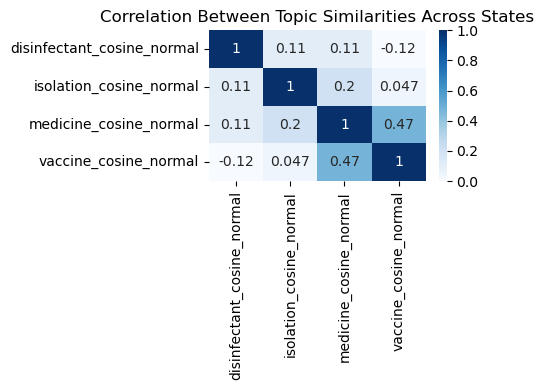


PCA explained variance ratio per component:
 PC1: 0.3839
 PC2: 0.2840
 PC3: 0.2156
 PC4: 0.1165
Cumulative variance explained:
 up to PC1: 0.3839
 up to PC2: 0.6679
 up to PC3: 0.8835
 up to PC4: 1.0000


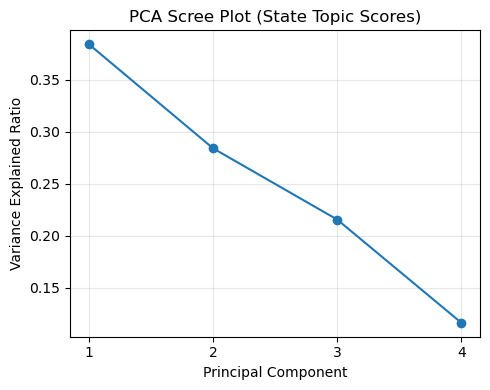


=== DIAGNOSTIC ANALYSIS END ===


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# =========================
# DIAGNOSTIC ANALYSIS CELL
# =========================
# Assumes you already have `state_topic_df` from Q6 with columns:
# ['state', 'disinfectant_cosine_normal', 'isolation_cosine_normal',
#  'medicine_cosine_normal', 'vaccine_cosine_normal']
# and you already ran k-means and spectral clustering to get:
# state_topic_df['kmeans_cluster'], state_topic_df['spectral_cluster']

print("=== DIAGNOSTIC ANALYSIS START ===")

topic_cols = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]

X = state_topic_df[topic_cols].values

# -------------------------------------------------
# 1. Show basic spread (min/max/range per feature)
# -------------------------------------------------
desc = state_topic_df[topic_cols].describe().T
desc["range"] = desc["max"] - desc["min"]
print("\nFeature spread across states:")
print(desc[["min", "max", "mean", "std", "range"]].round(4))

# -------------------------------------------------
# 2. Correlation heatmap between topics
# -------------------------------------------------
corr_mat = state_topic_df[topic_cols].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_mat, annot=True, vmin=0, vmax=1, cmap="Blues")
plt.title("Correlation Between Topic Similarities Across States")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. PCA variance explained
# -------------------------------------------------
# Scale first, so PCA isn't dominated by one feature's scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4, random_state=42)
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

print("\nPCA explained variance ratio per component:")
for i, val in enumerate(explained, start=1):
    print(f" PC{i}: {val:.4f}")

print("Cumulative variance explained:")
for i, val in enumerate(cumulative, start=1):
    print(f" up to PC{i}: {val:.4f}")

# Plot scree curve (variance explained)
plt.figure(figsize=(5,4))
plt.plot(range(1, len(explained)+1), explained, marker="o")
plt.xticks(range(1, len(explained)+1))
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained Ratio")
plt.title("PCA Scree Plot (State Topic Scores)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== DIAGNOSTIC ANALYSIS END ===")


---

## Part VII: Determining Optimal Clusters
### Q8: Calinski–Harabasz Score Evaluation

In this step, I calculate the **Calinski–Harabasz (CH) score** for both **K-Means** and **Spectral Clustering** algorithms across different cluster counts (k = 2 to 20).  
The CH score helps identify the number of clusters that best separates the data — higher values indicate more distinct, well-defined clusters.  
By comparing both algorithms, I can determine which approach produces clearer topic-based groupings among the U.S. states.


Calculating Calinski–Harabasz scores for k = 2–20...


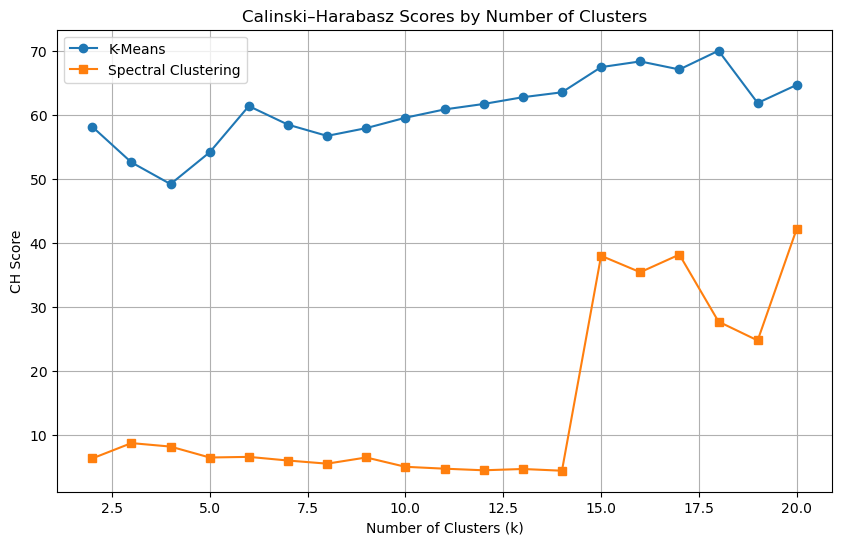


Best K-Means CH score: 70.06 at k = 18
Best Spectral CH score: 42.24 at k = 20

Elapsed time for Q8: 0.72 seconds


In [33]:
start_time = time.time()

from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# reload dataset
state_topic_df = pd.read_csv("state_topic_score_data.csv")
X = state_topic_df[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]]

# define range of cluster numbers
k_values = range(2, 21)
kmeans_scores = []
spectral_scores = []

print("Calculating Calinski–Harabasz scores for k = 2–20...")

for k in k_values:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_score = calinski_harabasz_score(X, kmeans_labels)
    kmeans_scores.append(kmeans_score)
    
    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  random_state=42, assign_labels='kmeans')
    spectral_labels = spectral.fit_predict(X)
    spectral_score = calinski_harabasz_score(X, spectral_labels)
    spectral_scores.append(spectral_score)

# visualize
plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_scores, marker='o', label='K-Means')
plt.plot(k_values, spectral_scores, marker='s', label='Spectral Clustering')
plt.title("Calinski–Harabasz Scores by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("CH Score")
plt.legend()
plt.grid(True)
plt.show()

# report best scores
best_k_kmeans = k_values[np.argmax(kmeans_scores)]
best_k_spectral = k_values[np.argmax(spectral_scores)]

print(f"\nBest K-Means CH score: {max(kmeans_scores):.2f} at k = {best_k_kmeans}")
print(f"Best Spectral CH score: {max(spectral_scores):.2f} at k = {best_k_spectral}")

elapsed_time_q8 = time.time() - start_time
print(f"\nElapsed time for Q8: {elapsed_time_q8:.2f} seconds")


---

## Part VII Summary – Optimal Cluster Evaluation (Q8)

These results confirm the findings from Q7: K-Means produces more coherent and well-separated clusters, while Spectral Clustering struggles to find meaningful boundaries in this low-dimensional dataset. Therefore, K-Means is the preferred method for this state-level topic-similarity data.


---

## Part VIII: Descriptive Visualization
### Q9: Parallel Coordinates Plot for States

In this step, I create a **parallel coordinates plot** to visualize how states differ across the four topic similarity scores: disinfectant, isolation, medicine, and vaccine.  
Each line in the plot represents a U.S. state, showing how topic emphasis varies across the axes.  
The goal is to identify whether any clear topic-based patterns or clusters emerge among states.


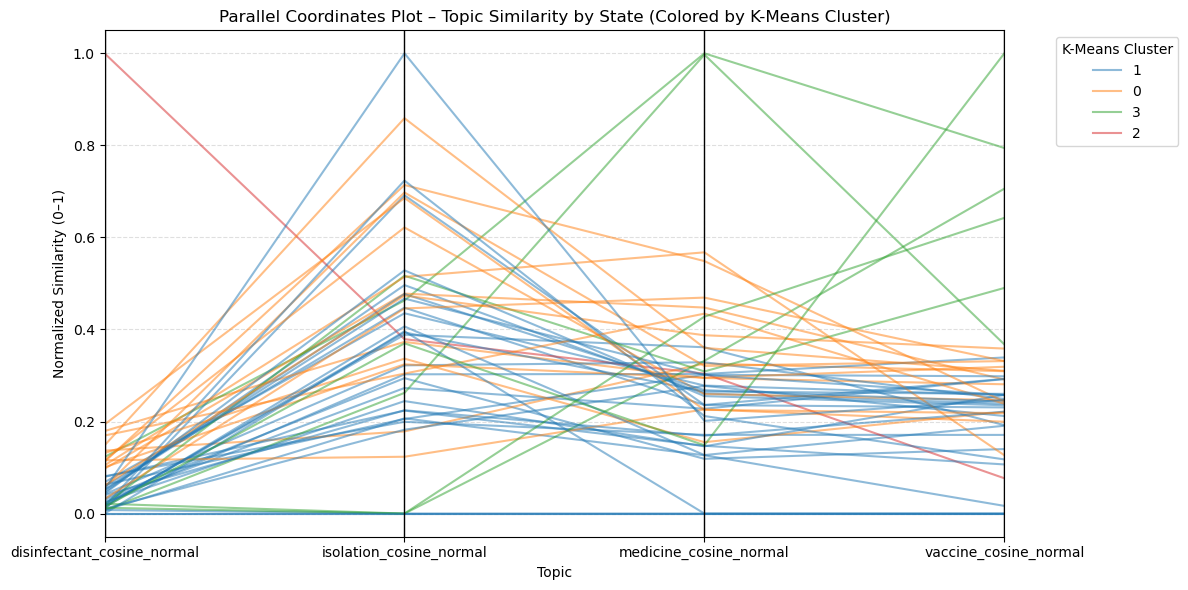

Elapsed time for Q9: 0.19 seconds


In [34]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans, SpectralClustering
import pandas as pd
import numpy as np
import time

start_time = time.time()

# 1️⃣ Reload the base dataset
state_topic_df = pd.read_csv("state_topic_score_data.csv")

# 2️⃣ Recreate K-Means and Spectral Clustering
X = state_topic_df[
    ["disinfectant_cosine_normal", "isolation_cosine_normal",
     "medicine_cosine_normal", "vaccine_cosine_normal"]
]

# K-Means (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
state_topic_df["kmeans_cluster"] = kmeans.fit_predict(X)

# Spectral Clustering (4 clusters)
spectral = SpectralClustering(
    n_clusters=4, affinity="nearest_neighbors", random_state=42
)
state_topic_df["spectral_cluster"] = spectral.fit_predict(X)

# 3️⃣ Add Category column for coloring
state_topic_df["Category"] = state_topic_df["kmeans_cluster"].astype(str)

# 4️⃣ Normalize again for consistent visualization
cols = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]
state_topic_df[cols] = state_topic_df[cols].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# 5️⃣ Plot colored by K-Means cluster
plt.figure(figsize=(12, 6))
parallel_coordinates(
    state_topic_df,
    class_column="Category",
    cols=cols,
    color=plt.cm.tab10.colors[:state_topic_df["Category"].nunique()],
    alpha=0.5
)
plt.title("Parallel Coordinates Plot – Topic Similarity by State (Colored by K-Means Cluster)")
plt.xlabel("Topic")
plt.ylabel("Normalized Similarity (0–1)")
plt.legend(title="K-Means Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

elapsed_time_q9 = time.time() - start_time
print(f"Elapsed time for Q9: {elapsed_time_q9:.2f} seconds")



These differences highlight that states vary in their dominant COVID-19 discussion themes, and clustering successfully captures these patterns even when numerical differences are subtle.

# ## Q10 – Regional Topic Trends Visualization
In this question, we analyze how average topic similarity scores (disinfectant, isolation, medicine, and vaccine) vary across U.S. regions (Midwest, Northeast, South, and West). The grouped bar chart below visualizes these differences, helping identify which regions emphasized particular topics more in COVID-related discussions.

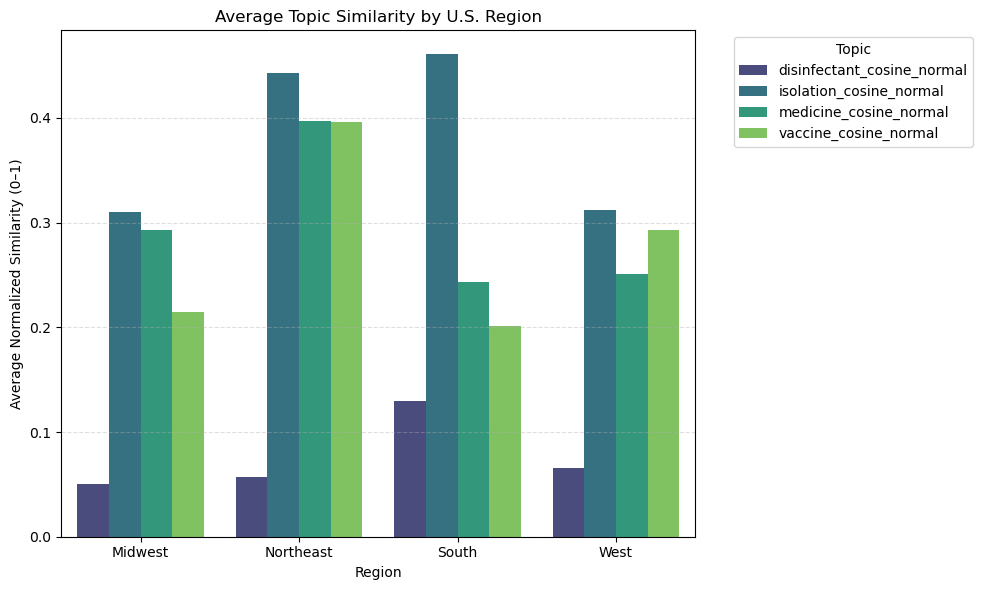

Elapsed time for Q10: 0.17 seconds

Regional averages:
       region  disinfectant_cosine_normal  isolation_cosine_normal  \
0    Midwest                      0.0504                   0.3100   
1  Northeast                      0.0567                   0.4428   
2      South                      0.1295                   0.4607   
3       West                      0.0659                   0.3118   

   medicine_cosine_normal  vaccine_cosine_normal  
0                  0.2932                 0.2148  
1                  0.3968                 0.3964  
2                  0.2436                 0.2011  
3                  0.2508                 0.2934  


In [35]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import time

start_time = time.time()

# Merge regional info back into the state_topic_df using the unique state field
# (this assumes tweets_us_df still contains `state` and `region`)
region_map = tweets_us_df[["state", "region"]].drop_duplicates()
state_topic_df = state_topic_df.merge(region_map, on="state", how="left")

# Group by region to compute mean similarity per topic
region_topic_df = state_topic_df.groupby("region")[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]].mean().reset_index()

# Melt for plotting
region_melted = region_topic_df.melt(
    id_vars="region",
    var_name="Topic",
    value_name="Average Similarity"
)

# Create grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=region_melted,
    x="region",
    y="Average Similarity",
    hue="Topic",
    palette="viridis"
)
plt.title("Average Topic Similarity by U.S. Region")
plt.xlabel("Region")
plt.ylabel("Average Normalized Similarity (0–1)")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

elapsed_time_q10 = time.time() - start_time
print(f"Elapsed time for Q10: {elapsed_time_q10:.2f} seconds")

# Preview numerical results
print("\nRegional averages:\n", region_topic_df.round(4))

These findings suggest that topic emphasis during the pandemic varied regionally, with some areas focusing more on health interventions and others on personal or preventive measures.

## Q11 – PCA Visualization of Clustering Results

In this question, we apply Principal Component Analysis (PCA) to reduce the
four-dimensional topic similarity data (disinfectant, isolation, medicine,
vaccine) into two principal components. Two scatterplots are created:
one colored by K-Means cluster assignments and one by Spectral Clustering.
This visualization helps assess whether the discovered clusters form
distinct groups in the reduced 2D space.


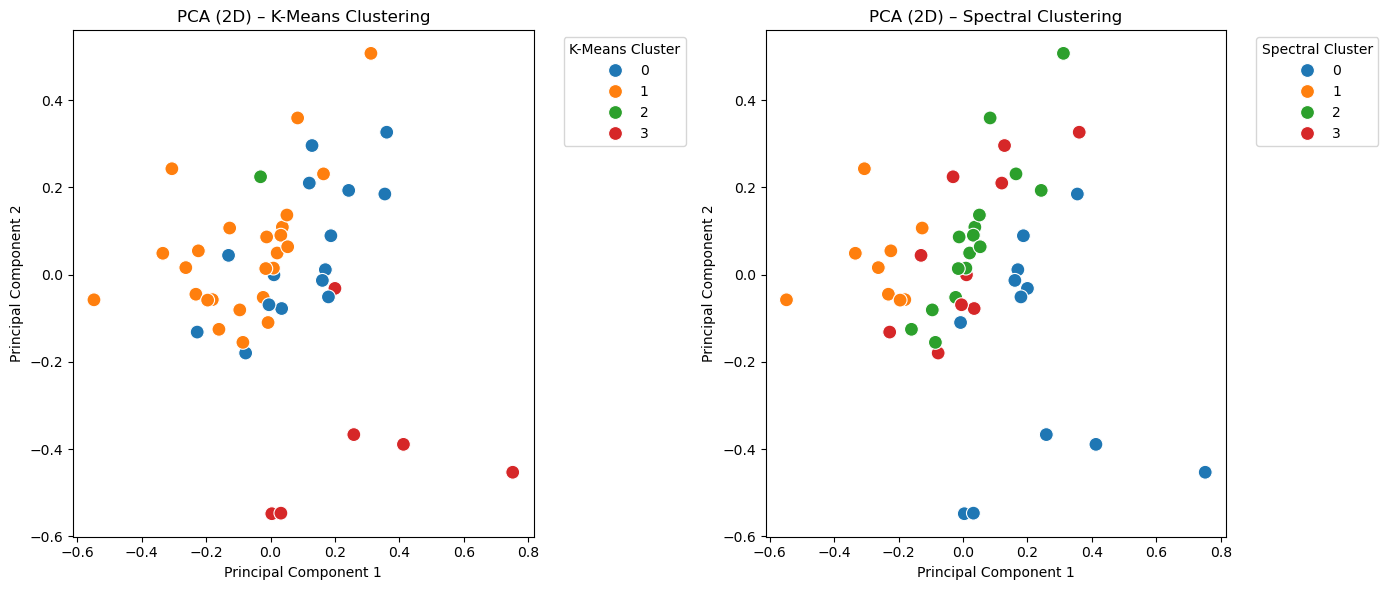

[0.42009092 0.31150714]
Elapsed time for Q11: 0.98 seconds


In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import time

start_time = time.time()

# Select topic-related features for PCA
topic_features = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]

# Run PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(state_topic_df[topic_features])
state_topic_df["PCA1"] = pca_result[:, 0]
state_topic_df["PCA2"] = pca_result[:, 1]

# Plot side-by-side scatterplots for K-Means and Spectral Clustering
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means
sns.scatterplot(
    data=state_topic_df,
    x="PCA1", y="PCA2",
    hue="kmeans_cluster",
    palette="tab10", s=100, ax=axes[0]
)
axes[0].set_title("PCA (2D) – K-Means Clustering")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(title="K-Means Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Spectral Clustering
sns.scatterplot(
    data=state_topic_df,
    x="PCA1", y="PCA2",
    hue="spectral_cluster",
    palette="tab10", s=100, ax=axes[1]
)
axes[1].set_title("PCA (2D) – Spectral Clustering")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title="Spectral Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

elapsed_time_q11 = time.time() - start_time
print(pca.explained_variance_ratio_)
print(f"Elapsed time for Q11: {elapsed_time_q11:.2f} seconds")
